- 7 classes of documents
- 20 docs/class labeled
- features/document: 1433 words, an undirected graph where each doc is a node and citations = edges
- classify documents

Resources
---------
* Dataset: https://graphsandnetworks.com/the-cora-dataset/
* Intro videos, only 20 min total: https://www.youtube.com/watch?v=XRHhtLgpXqg and https://www.youtube.com/watch?v=Zjx25h8DnIo
* very good, concise blog post by author of paper: https://tkipf.github.io/graph-convolutional-networks/
* paper github repo https://github.com/tkipf/gcn/blob/master/gcn/train.py

In [ ]:
# Load data, only needed once
!mkdir data
!curl https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz -o data/cora.tgz
!tar -xzf ./data/cora.tgz -C ./data/
!rm ./data/cora.tgz

In [63]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import networkx as nx
import tensorflow as tf
import stellargraph as sg
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from stellargraph.layer.gcn import GraphConvolution, GatherIndices

## Question 23
classify using graph convolutional nets

In [137]:
# Unpack Data
edgelist = pd.read_csv('./data/cora/cora.cites', sep='\t', header=None, names=["target", "source"])
column_names = [f"w_{i}" for i in range(1433)] + ["subject"]
node_data = pd.read_csv('./data/cora/cora.content', sep='\t', header=None, names=column_names)
node_data['subject'] = pd.Categorical(node_data.subject).codes

# Nodes have weird values like 11573 when there are only 2708 nodes. We map them to [0,2708]
node_mapping = dict(zip(node_data.index, np.arange(len(node_data.index))))
edgelist['target'] = edgelist['target'].map(node_mapping)
edgelist['source'] = edgelist['source'].map(node_mapping)
node_data.index = node_data.index.map(node_mapping)

# Calculate Normalized Adjacency Matrix from GCN Paper
g = sg.StellarGraph(node_data, edgelist)
A      = g.to_adjacency_matrix(weighted=True) # adjacency matrix
A_t    = A + np.eye(A.shape[0]) - A.diagonal() # add self-connections to each node
D_t    = np.diag(np.power(np.array(A_t.sum(axis=1)), -0.5)[:,0]) # symmetric normalization matrix
A_norm = D_t @ A @ D_t # normalized adjacency matrix

# Test/Train/Validation Split
train_nodes = []
for subject in node_data.subject.unique():
    train_nodes += node_data[node_data['subject'] == subject].sample(20).index.to_list()
test_nodes = list(set(node_data.index) - set(train_nodes))
val_nodes, test_nodes = model_selection.train_test_split(
    test_nodes, train_size=0.8, stratify=node_data.loc[test_nodes]['subject']
)

# Data Preprocessing
target_encoding = LabelBinarizer()
y_train = target_encoding.fit_transform(node_data.loc[train_nodes]['subject'])[None]
y_test = target_encoding.transform(node_data.loc[test_nodes]['subject'])[None]
y_val = target_encoding.transform(node_data.loc[val_nodes]['subject'])[None]

features_input = node_data.to_numpy()[None]
A_input = A_norm[None]

train_indices = np.array(train_nodes)[None]
test_indices = np.array(test_nodes)[None]
val_indices = np.array(val_nodes)[None]

In [256]:
class GCN:
    """Graph Convolutional Network Model
    
    Attributes
    ----------
    model : tensorflow.keras.Model

    Methods
    -------
    fit()
        Fit the model to the data
    predict()
        Predict the class of the nodes
    evaluate()
        Evaluate the model on the test data
    """
    
    def __init__(self, 
        kernel_initializer="glorot_uniform", 
        bias_initializer="zeros",
        layer1_size: int=32,
        layer2_size: int=32,
        input_dropout: float=0.9,
        hidden_dropout: float=0.5,
        epochs=20,
        batch_size=1,
        early_stopping=10,
        learning_rate=1e-2,
        weight_decay=5e-4
    ):
        """Initialise the GCN model
        
        Parameters
        ----------
        kernel_initializer : str, optional
            Initializer for the weights matrix, by default "glorot_uniform"
        bias_initializer : str, optional
            Initializer for the bias vector, by default "zeros"
        layer1_size : int, optional
            Number of nodes in the first hidden layer, by default 32, if None, then no hidden layer
        layer2_size : int, optional
            Number of nodes in the second hidden layer, by default 32, if None, then no hidden layer
        input_dropout : float, optional
            Dropout rate for the input layer, by default 0.9
        hidden_dropout : float, optional
            Dropout rate for the hidden layers, by default 0.5
        """
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping

        # Build the model
        # Create input layer
        n_features = features_input.shape[2]
        n_nodes = features_input.shape[1] # number of classes
        x_features = Input(batch_shape=(1, n_nodes, n_features))
        x_indices = Input(batch_shape=(1, None), dtype="int32")
        x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
        x_input  = [x_features, x_indices, x_adjacency]

        # Hidden Layers
        x = Dropout(input_dropout)(x_features)
        if layer1_size:
            x = GraphConvolution(
                layer1_size,
                activation='relu',
                use_bias=True,
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer,
            )([x, x_adjacency])
            x = Dropout(hidden_dropout)(x)
        if layer2_size:
            x = GraphConvolution(
                layer2_size,
                activation='relu',
                kernel_initializer=kernel_initializer,
                bias_initializer=bias_initializer
            )([x, x_adjacency])
            x = GatherIndices(batch_dims=1)([x, x_indices])
        output = Dense(7, activation='softmax')(x)

        self.model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)

        # Compile model
        self.model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
            loss=tf.losses.categorical_crossentropy,
            metrics=["acc"],
        )

    def fit(self, features_input, train_indices, A_input, y_train, y_val, val_indices):
        # Early stopping callback
        es_callback = EarlyStopping(monitor="val_acc", patience=self.early_stopping, restore_best_weights=True)

        # Train model
        history = self.model.fit(
            x = [features_input, train_indices, A_input],
            y = y_train,
            epochs=self.epochs,
            verbose=0,
            validation_data=([features_input, val_indices, A_input], y_val),
            shuffle=False,
            callbacks=[es_callback],
            batch_size=self.batch_size,
        )
        sg.utils.plot_history(history)
        
        return history

    def predict(self, features_input, test_indices, A_input):
        return self.model.predict([features_input, test_indices, A_input])

    def evaluate(self, features_input, test_indices, A_input, y_test) -> None:
        test_metrics = self.model.evaluate(
            x = [features_input, test_indices, A_input],
            y = y_test,
            verbose=0,
            batch_size=self.batch_size,
        )
        print(f"Test Set Metrics:\nLoss - {test_metrics[0]}\nAccuracy - {test_metrics[1]}")

Test Set Metrics:
Loss - 0.6963570713996887
Accuracy - 0.801556408405304


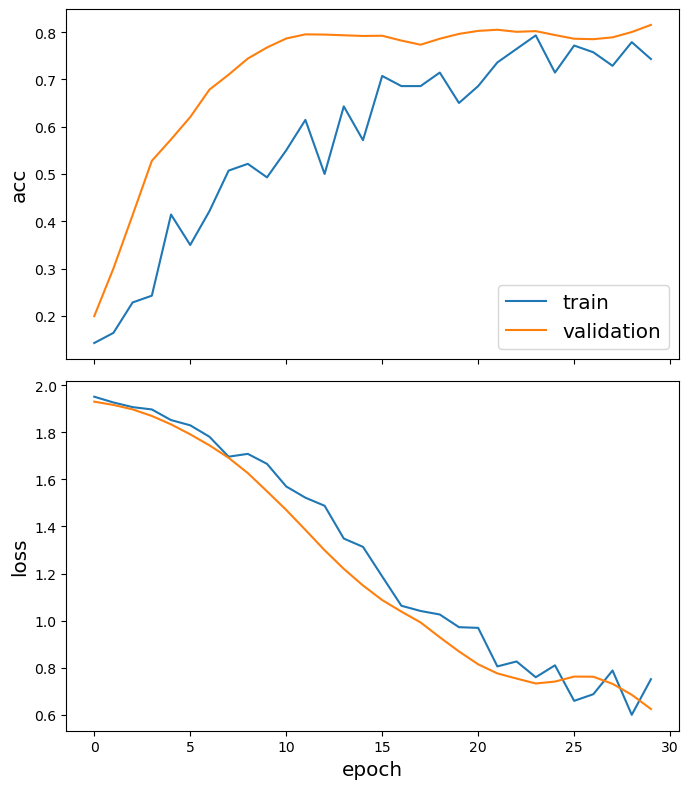

In [261]:
gcn = GCN(epochs=30)
gcn.fit(features_input, train_indices, A_input, y_train, y_val, val_indices)
gcn.evaluate(features_input, test_indices, A_input, y_test)

## Question 24

## Question 25